In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import *

## 데이터 설명

본 연구에서는 서로 다른 두 종목에 대한 페어트레이딩 가능성을 탐색하기 위해 2016년 5월 28일 부터 2021년 5월 28일까지의 5년치 데이터를 사용하였다. 저유동성으로 인한 일시적인 가격 왜곡을 최소화하고 실현 가능한 전략을 구현하기 위해 KOSPI 200 지수에 편입된 종목을 대상으로 선정하였다. 생존편향을 제거하기 위해 시작일(2016/05/28) 기준으로 역대 KOSPI200 지수에 편입된 모든 종목을 사용하여 분석을 진행하였다.

## 데이터  로딩

In [2]:
raw = pd.read_csv("rawdata.csv")

In [3]:
raw.head()

,Symbol,A005930,A000660,A035420,A051910,A035720,A207940,A005380,A006400,A068270,...,A042100,A051310,A053000,A060000,A063350,A064420,A067250,A068870,A103130,A103150
0,Symbol Name,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,...,현대오토넷,포스코플랜텍,우리금융,국민은행,팬택앤큐리텔,케이피케미칼,STX조선해양,LG생명과학,웅진에너지,하이트맥주
1,2016-05-28,25640,28650,140199,275000,20272,0,136000,108000,83294,...,0,0,0,0,0,0,0,69100,8966,0
2,2016-05-29,25640,28650,140199,275000,20272,0,136000,108000,83294,...,0,0,0,0,0,0,0,69100,8966,0
3,2016-05-30,25600,29000,142202,273000,20715,0,136500,107000,83639,...,0,0,0,0,0,0,0,70700,9283,0
4,2016-05-31,25840,28700,144205,271000,20715,0,139500,112500,85361,...,0,0,0,0,0,0,0,69900,9085,0


In [4]:
raw.tail()

,Symbol,A005930,A000660,A035420,A051910,A035720,A207940,A005380,A006400,A068270,...,A042100,A051310,A053000,A060000,A063350,A064420,A067250,A068870,A103130,A103150
1823,2021-05-24,79700,119500,355500,892000,116500,858000,228000,635000,262000,...,0,0,0,0,0,0,0,0,0,0
1824,2021-05-25,79900,123000,358000,892000,118000,850000,227500,643000,272000,...,0,0,0,0,0,0,0,0,0,0
1825,2021-05-26,79800,123000,363000,832000,119500,835000,223500,637000,270500,...,0,0,0,0,0,0,0,0,0,0
1826,2021-05-27,79600,125500,358000,803000,125000,817000,220500,636000,269000,...,0,0,0,0,0,0,0,0,0,0
1827,2021-05-28,80100,125000,358000,832000,122000,827000,232000,640000,273500,...,0,0,0,0,0,0,0,0,0,0


# 데이터 전처리

In [5]:
len(raw.columns)

505

In [6]:
# index, column 세팅
symbol_names = list(raw.iloc[0, 1:])
dates = pd.to_datetime(list(raw.iloc[1:, 0]), format="%Y-%m-%d")

price = raw.iloc[1:, 1:]
price.columns = symbol_names
price.index = pd.to_datetime(dates, format="%Y-%m-%d")

In [7]:
price.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,현대오토넷,포스코플랜텍,우리금융,국민은행,팬택앤큐리텔,케이피케미칼,STX조선해양,LG생명과학,웅진에너지,하이트맥주
2016-05-28,25640,28650,140199,275000,20272,0,136000,108000,83294,46350,...,0,0,0,0,0,0,0,69100,8966,0
2016-05-29,25640,28650,140199,275000,20272,0,136000,108000,83294,46350,...,0,0,0,0,0,0,0,69100,8966,0
2016-05-30,25600,29000,142202,273000,20715,0,136500,107000,83639,45750,...,0,0,0,0,0,0,0,70700,9283,0
2016-05-31,25840,28700,144205,271000,20715,0,139500,112500,85361,46650,...,0,0,0,0,0,0,0,69900,9085,0
2016-06-01,26660,28500,137595,269500,19848,0,138000,117000,85017,46500,...,0,0,0,0,0,0,0,71000,9164,0


In [8]:
# 가격이 0원인 데이터는 None으로 처리
price.iloc[:, :] = np.array(price.iloc[:, :], dtype=np.float)
price = price.applymap(lambda x: np.nan if x == 0 else x)

In [9]:
# 모든 데이터가 NaN인 종목은 제거
valid_symbols = []

for symbol, col in price.iteritems():
    
    if not all(col.isna()):
        valid_symbols.append(symbol)

price = price[valid_symbols]

In [10]:
price.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,한솔아트원제지,도레이케미칼,포스코티엠씨,두산건설,두산건설,태림페이퍼,미래에셋증권,미래에셋증권,LG생명과학,웅진에너지
2016-05-28,25640.0,28650.0,140199.0,275000.0,20272.0,NaN,136000.0,108000.0,83294.0,46350.0,...,2770.0,19400.0,9950.0,NaN,4433.0,3710.0,7791.0,23800.0,69100.0,8966.0
2016-05-29,25640.0,28650.0,140199.0,275000.0,20272.0,NaN,136000.0,108000.0,83294.0,46350.0,...,2770.0,19400.0,9950.0,NaN,4433.0,3710.0,7791.0,23800.0,69100.0,8966.0
2016-05-30,25600.0,29000.0,142202.0,273000.0,20715.0,NaN,136500.0,107000.0,83639.0,45750.0,...,2695.0,19400.0,10000.0,NaN,4461.0,3690.0,7703.0,23450.0,70700.0,9283.0
2016-05-31,25840.0,28700.0,144205.0,271000.0,20715.0,NaN,139500.0,112500.0,85361.0,46650.0,...,2690.0,19350.0,10000.0,NaN,4607.0,3660.0,7752.0,23450.0,69900.0,9085.0
2016-06-01,26660.0,28500.0,137595.0,269500.0,19848.0,NaN,138000.0,117000.0,85017.0,46500.0,...,2730.0,19500.0,10000.0,NaN,4649.0,3700.0,7733.0,23450.0,71000.0,9164.0


### 주말/공휴일 처리

In [11]:
# 주말 처리
weekends = [d for d in dates if d.weekday() in [5, 6]] # 토요일, 일요일
weekdays = [d for d in dates if not d in weekends]

price = price.loc[weekdays]

In [12]:
len(weekdays), len(weekends)

(1305, 522)

In [13]:
# 공휴일 처리
holidays = []

for ((t1, row1), (t2, row2)) in zip(list(price.iterrows())[:-1], list(price.iterrows())[1:]):
    
    is_holiday = True
    
    for r1, r2 in zip(row1, row2):
        if (r1 is None) and (r2 is None):
            continue

        if np.isnan(r1) and np.isnan(r2):
            continue
        
        if r1 != r2:
            is_holiday = False
            break
    
    if is_holiday:
        holidays.append(t2)

In [14]:
len(holidays)

76

In [15]:
business_days = [d for d in weekdays if not d in holidays]

price = price.loc[business_days]

In [16]:
len(holidays), len(business_days)

(76, 1229)

In [17]:
price.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,한솔아트원제지,도레이케미칼,포스코티엠씨,두산건설,두산건설,태림페이퍼,미래에셋증권,미래에셋증권,LG생명과학,웅진에너지
2016-05-30,25600.0,29000.0,142202.0,273000.0,20715.0,NaN,136500.0,107000.0,83639.0,45750.0,...,2695.0,19400.0,10000.0,NaN,4461.0,3690.0,7703.0,23450.0,70700.0,9283.0
2016-05-31,25840.0,28700.0,144205.0,271000.0,20715.0,NaN,139500.0,112500.0,85361.0,46650.0,...,2690.0,19350.0,10000.0,NaN,4607.0,3660.0,7752.0,23450.0,69900.0,9085.0
2016-06-01,26660.0,28500.0,137595.0,269500.0,19848.0,NaN,138000.0,117000.0,85017.0,46500.0,...,2730.0,19500.0,10000.0,NaN,4649.0,3700.0,7733.0,23450.0,71000.0,9164.0
2016-06-02,27300.0,28050.0,139598.0,269000.0,19647.0,NaN,138000.0,118000.0,84586.0,46050.0,...,2635.0,19400.0,10000.0,NaN,4659.0,3820.0,7743.0,23400.0,74400.0,9878.0
2016-06-03,27540.0,27600.0,141601.0,262500.0,19748.0,NaN,138500.0,111500.0,83725.0,46050.0,...,2570.0,19400.0,10000.0,NaN,4555.0,4000.0,7684.0,23350.0,73600.0,9918.0


In [18]:
price.tail()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,한솔아트원제지,도레이케미칼,포스코티엠씨,두산건설,두산건설,태림페이퍼,미래에셋증권,미래에셋증권,LG생명과학,웅진에너지
2021-05-24,79700.0,119500.0,355500.0,892000.0,116500.0,858000.0,228000.0,635000.0,262000.0,82300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,NaN,NaN,NaN
2021-05-25,79900.0,123000.0,358000.0,892000.0,118000.0,850000.0,227500.0,643000.0,272000.0,81800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10050.0,NaN,NaN,NaN
2021-05-26,79800.0,123000.0,363000.0,832000.0,119500.0,835000.0,223500.0,637000.0,270500.0,81300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9980.0,NaN,NaN,NaN
2021-05-27,79600.0,125500.0,358000.0,803000.0,125000.0,817000.0,220500.0,636000.0,269000.0,80800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9860.0,NaN,NaN,NaN
2021-05-28,80100.0,125000.0,358000.0,832000.0,122000.0,827000.0,232000.0,640000.0,273500.0,84700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9860.0,NaN,NaN,NaN


## 문제가 있는 일부 종목 삭제

In [19]:
from collections import Counter

[(k, v) for k, v in Counter(price.columns).items() if v > 1]

[('삼성물산', 2), ('SK', 2), ('미래에셋증권', 4), ('두산건설', 2)]

In [20]:
# 제외 종목
excluded = ["삼성물산", "SK", "미래에셋증권", "두산건설"]
price = price[[c for c in price.columns if not c in excluded]]

### 수익률 변환

In [21]:
def price_to_return(arr):
    result = [np.nan]
    
    for (i1, p1), (i2, p2) in zip(enumerate(arr[:-1]), enumerate(arr[1:])):

        if np.isnan(p2) and all((np.isnan(x) for x in arr[i2:])): # 상장폐지 후 재 상장이 안된 경우

            result.append(-1.)
            
            for _ in range(len(arr) - (i2 + 2)):
                result.append(np.nan)
            
            break
        
        if np.isnan(p1) or p1 is None or np.isnan(p2) or p2 is None: # 거래 정지
            result.append(0.)
        else:
            result.append(p2/p1 -1)
            
    return np.array(result)

In [22]:
daily_rt = price.apply(price_to_return, axis=0)

In [23]:
daily_rt

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,현대증권,대덕GDS,동성화학,대성합동지주,한솔아트원제지,도레이케미칼,포스코티엠씨,태림페이퍼,LG생명과학,웅진에너지
2016-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,0.009375,-0.010345,0.014086,-0.007326,0.000000,0.000000,0.021978,0.051402,0.020588,0.019672,...,0.001562,0.011673,-0.003643,-0.024119,-0.001855,-0.002577,0.0,-0.008130,-0.011315,-0.021329
2016-06-01,0.031734,-0.006969,-0.045838,-0.005535,-0.041854,0.000000,-0.010753,0.040000,-0.004030,-0.003215,...,0.028081,0.023077,-0.001828,-0.011407,0.014870,0.007752,0.0,0.010929,0.015737,0.008696
2016-06-02,0.024006,-0.015789,0.014557,-0.001855,-0.010127,0.000000,0.000000,0.008547,-0.005070,-0.009677,...,-0.019727,-0.007519,0.029304,0.007692,-0.034799,-0.005128,0.0,0.032432,0.047887,0.077914
2016-06-03,0.008791,-0.016043,0.014348,-0.024164,0.005141,0.000000,0.003623,-0.055085,-0.010179,0.000000,...,0.006192,0.015152,-0.028470,0.005725,-0.024668,0.000000,0.0,0.047120,-0.010753,0.004049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,-0.004994,-0.024490,-0.012500,-0.002237,-0.004274,-0.003484,0.002198,-0.012442,-0.024209,-0.004837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-25,0.002509,0.029289,0.007032,0.000000,0.012876,-0.009324,-0.002193,0.012598,0.038168,-0.006075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-26,-0.001252,0.000000,0.013966,-0.067265,0.012712,-0.017647,-0.017582,-0.009331,-0.005515,-0.006112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-27,-0.002506,0.020325,-0.013774,-0.034856,0.046025,-0.021557,-0.013423,-0.001570,-0.005545,-0.006150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


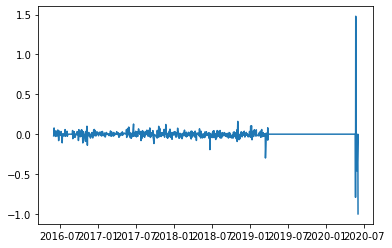

In [319]:
plt.plot(daily_rt['웅진에너지'])

## 데이터 전처리 모듈 개발

In [24]:
from abc import ABC, abstractclassmethod, abstractmethod

class Preprocessor(ABC):

    @abstractmethod
    def apply(self, data: pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class LogProcessor(Preprocessor):
    
    def apply(self, data: pd.DataFrame) -> pd.DataFrame:
        return data.apply(np.log)
    

class Winsorizer(Preprocessor):
    
    def __init__(self, low_bound:float, high_bound:float, axis:int =1):
        assert (low_bound > 0) and (low_bound < 100), "low_bound should be within 0 and 100"
        assert (high_bound > 0) or (high_bound < 100), "high_bound should be within 0 and 100"
        assert (low_bound < high_bound), "low_bound should be smaller than high_bound"
        assert axis in [0, 1], "axis should be in [0, 1]"
        
        self.low_bound = low_bound
        self.high_bound = high_bound
        self.axis = axis
        
    def apply(self, data: pd.DataFrame) -> pd.DataFrame:
        return data.apply(lambda arr: np.clip(
            arr, 
            np.nanpercentile(arr, self.low_bound),
            np.nanpercentile(arr, self.high_bound),
            ),
        axis=self.axis
        )

In [332]:
class DataTransformer(ABC):
    ''' data shape can differ after applying DataTransformer '''
    
    @abstractmethod
    def apply(self, data: pd.DataFrame) -> pd.DataFrame:
        pass

class DailyToWeeklyTransformer(DataTransformer):
    
    # 월별 수익률로 변환
    def _daily_to_weekly(self, arr):
        
        if -1.0 in arr: # 상장폐지
            return -1.0
            
        if all(np.isnan(x) for x in arr):
            return np.nan
        
        return np.prod(1+ arr) -1

    def daily_to_monthly(self, arr):
        return arr.groupby(pd.Grouper(freq="W")).apply(lambda arr: self._daily_to_weekly(arr))

    
    def apply(self, data:pd.DataFrame) -> pd.DataFrame:
        return data.apply(self.daily_to_monthly)

class DailyToMonthlyTransformer(DataTransformer):
    
    # 월별 수익률로 변환
    def _daily_to_monthly(self, arr):
        if -1.0 in arr: # 상장폐지
            return -1.0

        
        if all(np.isnan(x) for x in arr):
            return np.nan
        
        return np.prod(1+ arr) -1

    def daily_to_monthly(self, arr):
        return arr.groupby(pd.Grouper(freq="M")).apply(lambda arr: self._daily_to_monthly(arr))

    
    def apply(self, data:pd.DataFrame) -> pd.DataFrame:
        return data.apply(self.daily_to_monthly)
    
class DropNanTransformal(DataTransformer):
    
    def __init__(self, how:str="any", axis:int=0):
        self.how = how
        self.axis = axis
        
    def apply(self, data:pd.DataFrame) -> pd.DataFrame:
        return data.dropna(how=self.how, axis=self.axis)


In [333]:
class DataProcessor:
    
    def __init__(self):
        self.inners = []
        
    def add_preprocessor(self, x: Preprocessor):
        if not isinstance(x, Preprocessor):
            assert False, f"expected Preprocessor instance, but got {type(x)}"
            
        self.inners.append(x)
        
    def add_data_transformer(self, x: DataTransformer):
        if not isinstance(x, DataTransformer):
            assert False, f"expected DataTransformer instance, but got {type(x)}"
            
        self.inners.append(x)
        
    def apply(self, data):
        for processor in self.inners:
            data = processor.apply(data)
            
        return data

In [343]:
# 일별 수익률 데이터를 주별 수익률 데이터로 변환 
rt_processor = DataProcessor()
rt_processor.add_data_transformer(DailyToWeeklyTransformer()) # convert daily return to weekly return
#rt_processor.add_preprocessor(Winsorizer(0.5, 99.5, axis=1)) # cross-sectional(axis=1) winsorizing
weekly_rt = rt_processor.apply(daily_rt)

# 71주차는 모두 휴일이여서 앞의 값으로 채워준다
weekly_rt.iloc[70] = weekly_rt.iloc[69]
weekly_rt = weekly_rt.dropna(how="all", axis=0)


In [344]:
weekly_rt.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,현대증권,대덕GDS,동성화학,대성합동지주,한솔아트원제지,도레이케미칼,포스코티엠씨,태림페이퍼,LG생명과학,웅진에너지
2016-06-05,0.075781,-4.827586e-02,-0.004226,-0.038462,-0.046681,0.0,0.014652,0.042056,0.001028,0.006557,...,0.015625,0.042802,-0.005464,-2.226345e-02,-0.046382,0.000000,0.000000e+00,0.084011,0.041018,0.068405
2016-06-12,0.021060,5.072464e-02,0.018390,0.038095,-0.031649,0.0,0.003610,-0.008969,0.011311,0.005429,...,0.044615,-0.033582,-0.010989,-2.220446e-16,0.011673,0.005155,0.000000e+00,0.116250,0.059783,-0.004033
2016-06-19,0.014225,2.220446e-16,-0.043057,-0.049541,-0.037912,0.0,-0.032374,-0.013575,-0.051883,-0.031317,...,-0.060383,0.011583,-0.098148,-1.328273e-02,-0.109615,-0.005128,-1.110223e-16,0.475924,-0.083333,-0.007998
2016-06-26,-0.018233,9.655172e-02,0.072567,-0.073359,-0.001141,0.0,0.037175,-0.032110,-0.022534,-0.022297,...,-0.017241,-0.053435,-0.057495,-5.769231e-03,-0.066955,0.000000,5.000000e-03,-0.251138,-0.048951,-0.076947
2016-07-03,0.047143,1.100629e-02,-0.035180,0.075000,0.038418,0.0,-0.017921,0.028436,0.084529,-0.018244,...,0.014354,0.056452,0.122004,-3.675048e-02,0.069444,0.000000,-4.975124e-03,0.104357,0.080882,0.061360


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'weekly Return Distribution')

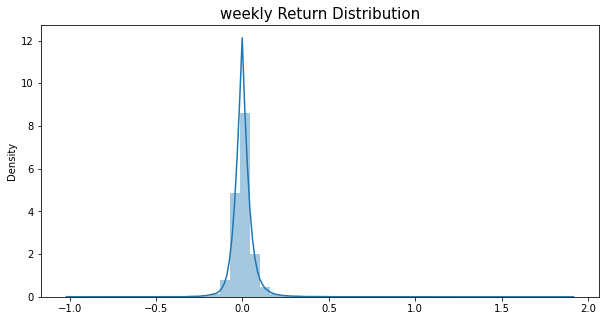

In [345]:
plt.figure(figsize=(10, 5))
sns.distplot(weekly_rt.values)
plt.title("weekly Return Distribution", size=15)

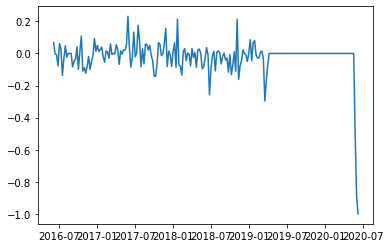

In [347]:
plt.plot(weekly_rt['웅진에너지'])

In [348]:
# 일별 가격을 주별 가격으로 변환 후 로그 적용
weekly_price = price.groupby(pd.Grouper(freq="W")).last()
weekly_log_price = LogProcessor().apply(weekly_price)

# 71주차는 모두 휴일이여서 앞의 값으로 채워준다
weekly_price.iloc[70] = weekly_price.iloc[69]
weekly_log_price.iloc[70] = weekly_log_price.iloc[69]

In [349]:
weekly_price.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,현대증권,대덕GDS,동성화학,대성합동지주,한솔아트원제지,도레이케미칼,포스코티엠씨,태림페이퍼,LG생명과학,웅진에너지
2016-06-05,27540.0,27600.0,141601.0,262500.0,19748.0,NaN,138500.0,111500.0,83725.0,46050.0,...,6500.0,13400.0,27300.0,26350.0,2570.0,19400.0,10000.0,4000.0,73600.0,9918.0
2016-06-12,28120.0,29000.0,144205.0,272500.0,19123.0,NaN,139000.0,110500.0,84672.0,46300.0,...,6790.0,12950.0,27000.0,26350.0,2600.0,19500.0,10000.0,4465.0,78000.0,9878.0
2016-06-19,28520.0,29000.0,137996.0,259000.0,18398.0,NaN,134500.0,109000.0,80279.0,44850.0,...,6380.0,13100.0,24350.0,26000.0,2315.0,19400.0,10000.0,6590.0,71500.0,9799.0
2016-06-26,28000.0,31800.0,148010.0,240000.0,18377.0,NaN,139500.0,105500.0,78470.0,43850.0,...,6270.0,12400.0,22950.0,25850.0,2160.0,19400.0,10050.0,4935.0,68000.0,9045.0
2016-07-03,29320.0,32150.0,142803.0,258000.0,19083.0,NaN,137000.0,108500.0,85103.0,43050.0,...,6360.0,13100.0,25750.0,24900.0,2310.0,19400.0,10000.0,5450.0,73500.0,9600.0


In [350]:
weekly_log_price.head()

,삼성전자,SK하이닉스,NAVER,LG화학,카카오,삼성바이오로직스,현대차,삼성SDI,셀트리온,기아,...,현대증권,대덕GDS,동성화학,대성합동지주,한솔아트원제지,도레이케미칼,포스코티엠씨,태림페이퍼,LG생명과학,웅진에너지
2016-06-05,10.223395,10.225571,11.860769,12.478006,9.890807,NaN,11.838626,11.621780,11.335293,10.737483,...,8.779557,9.503010,10.214642,10.179224,7.851661,9.873028,9.210340,8.294050,11.206400,9.202107
2016-06-12,10.244236,10.275051,11.878991,12.515394,9.858647,NaN,11.842229,11.612771,11.346540,10.742897,...,8.823206,9.468851,10.203592,10.179224,7.863267,9.878170,9.210340,8.404024,11.264464,9.198065
2016-06-19,10.258361,10.275051,11.834980,12.464583,9.819997,NaN,11.809319,11.599103,11.293263,10.711079,...,8.760923,9.480368,10.100287,10.165852,7.747165,9.873028,9.210340,8.793309,11.177453,9.190036
2016-06-26,10.239960,10.367222,11.905035,12.388394,9.818855,NaN,11.845820,11.566466,11.270472,10.688530,...,8.743532,9.425452,10.041073,10.160066,7.677864,9.873028,9.215328,8.504108,11.127263,9.109967
2016-07-03,10.286025,10.378168,11.869221,12.460715,9.856553,NaN,11.827736,11.594505,11.351618,10.670118,...,8.757784,9.480368,10.156190,10.122623,7.745003,9.873028,9.210340,8.603371,11.205041,9.169518


## 페어 선정 기간 및 트레이딩 기간 선정

In [351]:
pair_period = weekly_rt.index[:52*3] # 3년
trading_preiod = weekly_rt.index[52*3:] # 2년

# 분석 모듈 개발

In [352]:
def calc_spread(y: np.array, x: np.array):
    weights = np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y)).flatten()
    return y - x.dot(weights) # 잔차항



In [353]:
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

class TimeSeriesCombinationFilter(ABC):
    ''' 두 시계열의 조합에 대한 조건 검색을 위한 필터'''
    
    @abstractmethod
    def apply(self, data:pd.DataFrame, fixed_sets:List[Tuple[str, str]]= None):
        pass
    
class CorrelationFilter(TimeSeriesCombinationFilter):
    ''' 두 시계열의 상관계수를 기준으로 하는 필터'''
    
    def __init__(self, threshold: float):
        assert (threshold > 0) or (threshold < 1), "correlation threshold should be with 0 and 1"

        self.threshold = threshold
        
    def apply(self, data:pd.DataFrame, fixed_sets:List[Tuple[str, str]]= None) -> Tuple[str, str]:
        
        result = []
        cols = {i: c for i, c in enumerate(data)}
        
        combs = None
        if fixed_sets is not None:
            combs = fixed_sets
        else:
            combs = list(combinations(list(data.columns), 2))
        
        for x, y in tqdm(combs):
            
            tmp_data = data[[y, x]].dropna()            
            if len(tmp_data) < 30: # 30개월 이상의 데이터가 존재하지 않는 경우, 분석을 수행하지 않는다.
                continue
            
            arr = np.array(tmp_data)            
            arr1 = arr[:, 0]
            arr2 = arr[:, 1]
            
            corr = np.corrcoef(arr1, arr2)[0][1]
            
            if corr > self.threshold:
                result.append((x, y))
                
        return result
    
# class AbsoluteBetaFilter(TimeSeriesCombinationFilter):
#     ''' 두 시계열의 베타가 1에 가까운 것을 찾는다 '''
    
#     def __init__(self, threshold: float):
#         self.threshold = threshold
        
#     def apply(self, data:pd.DataFrame, fixed_sets:List[Tuple[str, str]]= None) -> Tuple[str, str]:
        
#         result = []
        
#         combs = None
#         if fixed_sets is not None:
#             combs = fixed_sets
#         else:
#             combs = list(combinations(list(data.columns), 2))
        
#         for x, y in combs:
#             arr1 = np.array(data[x])
#             arr2 = np.array(data[y])

#             cov = np.cov(arr1, arr2)
#             beta = cov[0, 1] / cov[1, 1]

#             if np.abs(1 - beta) > self.threshold:
#                 result.append((x, y))
                
#         return result
        
class CointegrationFilter(TimeSeriesCombinationFilter):
    '''두 시계열의 공적분 계수의 유의성(p-value)를 기준으로 하는 필터'''
    
    def __init__(self, pvalue:float):
        assert (pvalue > 0) or (pvalie < 1), "pvalue should be with 0 and 1"
        
        self.pvalue = pvalue
        
    def apply(self, data:pd.DataFrame, fixed_sets:List[Tuple[str, str]]= None) -> Tuple[str, str]:
        
        result = []
        
        combs = None
        if fixed_sets is not None:
            combs = fixed_sets
        else:
            combs = list(combinations(list(data.columns), 2))
    
        for x, y in tqdm(combs):
            
            tmp_data = data[[y, x]]
            tmp_data = tmp_data.dropna()
            
            if len(tmp_data) < 30: # 30개월 이상의 데이터가 존재하지 않는 경우, 분석을 수행하지 않는다.
                continue
            
            arr = np.array(tmp_data)
            arr1 = arr[:, 0]
            arr2 = arr[:, 1]
            
            pvalue = coint(arr1, arr2, trend="ct")[1] # 두 시계열에 대한 공적분 검정 수행
            
            if pvalue < self.pvalue:
                result.append((x, y))
                
        return result

class SpreadNormailityFilter(TimeSeriesCombinationFilter):
    """ 단일 회귀분석으로 헷지비율을 계산한 이후, 두 시계열을 선형결합 하였을 때 스프레드가 정상성을 띄는지 검증하는 필터"""
    
    def __init__(self, pvalue:float):
        assert (pvalue > 0) or (pvalie < 1), "pvalue should be with 0 and 1"
    
        self.pvalue = pvalue
        
    def apply(self, data:pd.DataFrame, fixed_sets:List[Tuple[str, str]]= None) -> Tuple[str, str]:
        
        result = []
        
        combs = None
        if fixed_sets is not None:
            combs = fixed_sets
        else:
            combs = list(combinations(list(data.columns), 2))
            
        for x, y in tqdm(combs):
            
            tmp_data = data[[y, x]]
            tmp_data = tmp_data.dropna()
            
            if len(tmp_data) < 30: # 30개월 이상의 데이터가 존재하지 않는 경우, 분석을 수행하지 않는다.
                continue
            
            arr = np.array(tmp_data)
            
            data_y = arr[:, 0]
            data_x = sm.add_constant(arr[:, 1])
            try:
                resid = calc_spread(data_y, data_x)
            except: # singular matrix error가 가끔 발생
                continue
            pvalue = adfuller(resid)[1] # 잔차에 대한 ADF 검정 수행
            
            if pvalue < self.pvalue:
                result.append((x, y))
                
        return result

            

class TimeSeriesCombinationFilterGroup:
    ''' 여러 필터를 묶어서 한번에 적용하는 필터 그룹 '''
    
    def __init__(self):
        self.filters: List[Tuple[TimeSeriesCombinationFilter, pd.DataFrame]] = []
            
    def add_filter(self, _filter: TimeSeriesCombinationFilter, data: pd.DataFrame):
        if not isinstance(_filter, TimeSeriesCombinationFilter):
            assert False, f"expected TimeSeriesCombinationFilter instance, but got {type(_filter)}"
            
        self.filters.append((_filter, data))
        
    def apply(self, fixed_sets:List[Tuple[str, str]]= None) -> List[Tuple[str, str]]:
        
        if not self.filters:
            return None
        
        combs = None
        if fixed_sets is not None:
            combs = fixed_sets
        
        for _filter, data in self.filters:
            combs = _filter.apply(data, combs)
        
        return combs

In [385]:
filter_group = TimeSeriesCombinationFilterGroup()
filter_group.add_filter(CorrelationFilter(0.93), weekly_log_price.loc[pair_period]) # 로그 가격의 상관계수가 0.93 이상인 조합을 찾는다
filter_group.add_filter(CointegrationFilter(0.05), weekly_log_price.loc[pair_period]) # 로그 가격의 공적분 계수의 pvalue가 0.05 이하인 조합을 찾는다
#filter_group.add_filter(SpreadNormailityFilter(0.05), weekly_rt) # 수익률에 대한 회귀분석을 통해 헤지 비율(베타)을 계산한 후, 두 시계열을 선형결합한 잔차가 정상성을 띄는지 검정한다

result = filter_group.apply()

 96%|█████████▌| 81078/84666 [01:34<00:04, 869.06it/s]/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 234/234 [00:01<00:00, 117.23it/s]


In [388]:
len(result)

83

In [389]:
result

[('삼성바이오로직스', '코스모화학'),
 ('아모레G', '동서'),
 ('아모레G', 'CJ CGV'),
 ('녹십자', 'SK케미칼'),
 ('CJ', 'LG하우시스'),
 ('CJ', '한솔테크닉스'),
 ('CJ', 'WISCOM'),
 ('동서', 'LG상사'),
 ('동서', 'CJ CGV'),
 ('SK케미칼', '대교'),
 ('한샘', '넥센타이어'),
 ('한샘', '고려제강'),
 ('현대위아', '넥센타이어'),
 ('현대위아', '하이트진로홀딩스'),
 ('현대위아', '화신'),
 ('한전KPS', '에넥스'),
 ('한전KPS', '페이퍼코리아'),
 ('신세계인터내셔날', '아세아제지'),
 ('대한전선', '진원생명과학'),
 ('LG상사', 'CJ CGV'),
 ('LG상사', '계양전기'),
 ('LG상사', 'SJM홀딩스'),
 ('동원시스템즈', '넥센타이어'),
 ('동원시스템즈', '고려제강'),
 ('동원시스템즈', '서연'),
 ('동원시스템즈', '화신'),
 ('오리온홀딩스', '계양전기'),
 ('오리온홀딩스', '에넥스'),
 ('진원생명과학', '덕성'),
 ('진원생명과학', '하이트론'),
 ('LIG넥스원', 'BGF'),
 ('롯데하이마트', '한일홀딩스'),
 ('LG하우시스', '이수화학'),
 ('LG하우시스', '무학'),
 ('LG하우시스', '계양전기'),
 ('HDC', '삼양사'),
 ('코스모신소재', '삼화콘덴서'),
 ('넥센타이어', '고려제강'),
 ('넥센타이어', '서연'),
 ('넥센타이어', '넥센'),
 ('넥센타이어', '화신'),
 ('넥센타이어', '조광페인트'),
 ('동아쏘시오홀딩스', '동성화학'),
 ('한진중공업', '대교'),
 ('삼양사', '대교'),
 ('삼양사', '조광페인트'),
 ('삼양사', 'SJM홀딩스'),
 ('SGC에너지', '화신'),
 ('SGC에너지', 'KC그린홀딩스'),
 ('SGC에너지', '한솔아트원제지'),
 ('코

In [390]:
def draw_plots(x, y, x_label, y_label):
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)
    ax[0].plot(y, color = "royalblue", alpha=1, label=y_label)
    ax[0].twinx().plot(x, color = "orange", alpha=1, label=x_label)
    fig.legend()
    ax[0].set_title("Log Price Return")

    spread = calc_spread(y, sm.add_constant(x))
    ax[1].plot(spread, label="Spread")
    ax[1].axhline(np.mean(spread), color="orange")
    ax[0].set_title("Log Price Return")
    ax[1].legend(loc="best")
    ax[1].set_title("Spread")
    
    flag = False # 현재 포지션 보유 여부
    sign = None # -, +
    
    for (i, (t, s)) in enumerate(spread.items()):
        if i < 52*3: # 3개년은 페어 선정 기간으로 트레이딩을 하지 않는다.
            continue 

        past = spread[i-52:i]
        mean = np.mean(past)
        std = np.std(past)

        low_bound = mean - 2*std
        high_bound = mean + 2*std

        if (s < low_bound):
            
            if not flag:
                ax[1].scatter(t, s, marker="^", color="red", s=70)
                
                flag = True
                sign = "-"
                
        elif (s > high_bound):
            
            if not flag:
                
                ax[1].scatter(t, s, marker="v", color="red", s=70)
                
                flag = True
                sign = "+"
                
        else:
            if flag:
                if (sign == "+" and s < 0) or (sign == "-" and s > 0): # 청산점
                    ax[1].scatter(t, s, marker="o", color="red", s=70)
                    flag = False # 포지션 청산
                    sign = None                
                    
    return
    



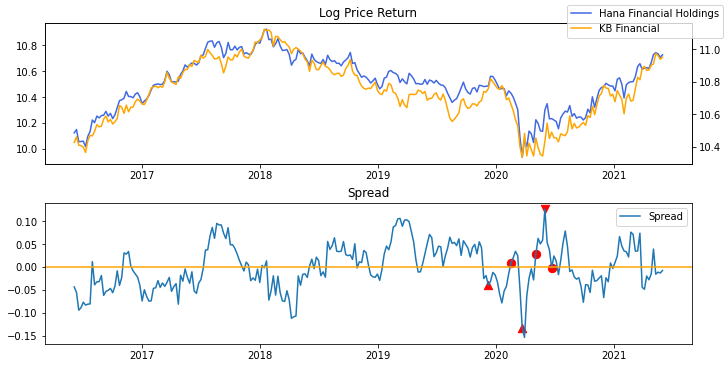

In [391]:
spread = draw_plots(weekly_log_price["KB금융"], weekly_log_price["하나금융지주"], "KB Financial", "Hana Financial Holdings")

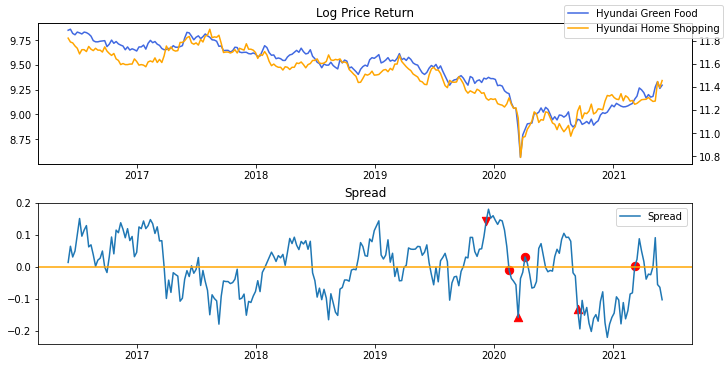

In [392]:
draw_plots(weekly_log_price["현대홈쇼핑"], weekly_log_price["현대그린푸드"], "Hyundai Home Shopping", "Hyundai Green Food")

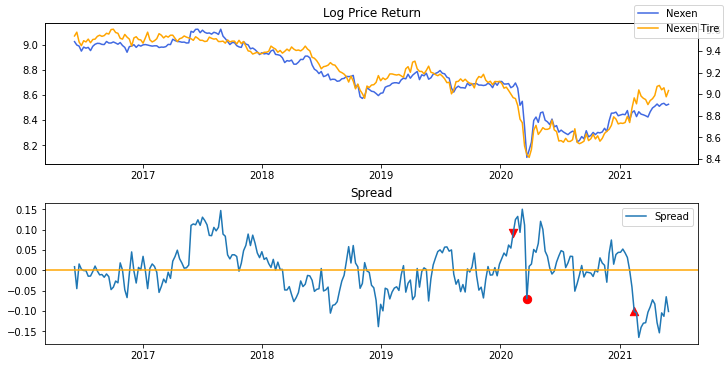

In [393]:
draw_plots(weekly_log_price["넥센타이어"], weekly_log_price["넥센"], "Nexen Tire", "Nexen")

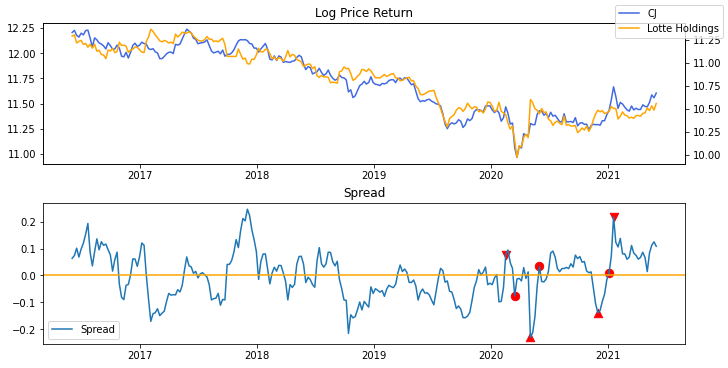

In [394]:
draw_plots(weekly_log_price["롯데지주"], weekly_log_price["CJ"], "Lotte Holdings", "CJ")

## 백테스팅 모듈 개발

In [468]:
import json

def calc_beta(x, y):
    return np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y)).flatten()

    
class TradingSummary:
    
    def __init__(self):
        self.x = None
        self.y = None
        
        self.w_x = None
        self.w_y = None
        
        self.start = None
        self.end = None
    
    @classmethod
    def start(cls, x:str, y:str, w_x:float, w_y:float, start:int):
        summary = TradingSummary()
        summary.x = x
        summary.y = y
        summary.w_x = w_x
        summary.w_y = w_y
        summary.start = start
        
        return summary
        
    def finish(self, end:int):
        self.end = end
        
    def __repr__(self):
        return str(self.__dict__)
    
class PairTradingBacktest:
    
    def __init__(self, k:int, h: int, s:float, price:pd.DataFrame, value:int):
        '''
        Parameters
            k:  int
                스프레드의 평균과 분산을 추정하기 위한 과거 look-back period

            h:  int
                최대 보유 기간
                
            s:  float
                진입 시점을 결정하는 파라미터(sigma)
                
            price:  pd.DataRame
                    가격 데이터

            rt:     pd.DataRame
                    수익률 데이터
                    
            value:  int
                    Long 포지션 기준 매수 금액
                    
        '''
        
        self.k = k
        self.h = h
        
        self.low_bound = -s
        self.high_bound = s
        
        self.price = price
        self.log_price = np.log(price)
        self.rt = rt
        self.value = value
    
    def calc_profit(self, trading_summary):
        x = trading_summary.x
        y = trading_summary.y
        
        start = trading_summary.start
        end = trading_summary.end

        p_x_start, p_y_start = self.price.iloc[start][x], self.price.iloc[start][y]
        p_x_end, p_y_end = self.price.iloc[end][x], self.price.iloc[end][y]

        w_x, w_y = trading_summary.w_x, trading_summary.w_y # x, y 종목 비중
        w_x_holding = None
        w_y_holding = None
        if w_y == 1: # y 매수
            
            w_y_holding = self.value / p_y_start # y종목 보유량
            w_x_holding = (w_x * self.value) / p_x_start # x종목 보유량
            
        elif w_y == -1: # y 매도
            
            w_y_holding = - (self.value / w_x) / p_y_start # x종목 보유량
            w_x_holding = self.value / p_x_start
        
        else:
            assert False # unreachable
            
        profit = ((p_x_end - p_x_start) * w_x_holding) + ((p_y_end - p_y_start) * w_y_holding)
        rt =  profit / self.value
        
        print(rt)
        if np.abs(rt) > 0.5:
            return summary
        return rt
        
    def run(self, x: str, y: str):
        
        log_price_x = np.array(self.log_price[x])
        log_price_y = np.array(self.log_price[y])
        
        trading_summaries = []
        trading_summary = None # 현재 보유중인 포지션에 대한 요약 정보
        spread_t = None # 포지션 진입 시점(t)에서 계산한 스프레드(베타 고정)
        
        for t in range(len(log_price_y)):
            if t < 52*3: # 3개년은 페어 선정 기간으로 트레이딩을 하지 않는다.
                continue 

            if trading_summary is not None: # 현재 포지션을 갖고 있음
                s = spread_t[t]
                
                if (trading_summary.w_y < 0 and s > 0) \
                    or (trading_summary.w_y > 0 and s < 0) \
                    or ((t - trading_summary.start) == self.h): # 청산점 혹은 최대 보유기간 경과
                    
                    # 포지션 청산
                    trading_summary.finish(t)
                    trading_summaries.append(trading_summary)
                    
                    trading_summary = None
                    continue
                    
            else:
                # recalcuate beta
                log_price_x_tmp = log_price_x[t-self.k : t]
                log_price_y_tmp = log_price_y[t-self.k : t]
                weights = calc_beta(x=sm.add_constant(log_price_x_tmp), y=log_price_y_tmp) # 과거 k주 수익률로 베타 계산
                hedge_ratio = weights[1]

                # 잔차항 정규화 (과거 k주 평균/분산으로)
                spread_t = log_price_y - sm.add_constant(log_price_x).dot(weights) # t시점의 잔차 시계열
                mean = np.mean(spread_t[t-self.k : t])
                std = np.std(spread_t[t-self.k : t])
                
                if np.isnan(std) or std == 0:
                    continue
                    
                s_t = (spread_t[t] - mean) / std # 오늘의 스프레드

                # 진입 여부
                if (s_t < self.low_bound): # x가 상대적으로 과대평가됨 (x 매수, y 매도)

                    # 신규 포지션 진입
                    if (np.abs(hedge_ratio) < 0.5) or (np.abs(hedge_ratio) > 2): # 레버리지 비율이 2배가 넘어가는 경우 트레이딩을 하지 않는다
                        continue
                    
                    w_x = hedge_ratio
                    w_y = -1
                    
                    #print(hedge_ratio)

                    trading_summary = TradingSummary.start(x, y, w_x, w_y, t)

                elif (s_t > self.high_bound): # x가 상대적으로 과소평가됨 (x 매도, y 매수)

                    # 신규 포지션 진입
                    if np.abs(hedge_ratio) < 0.5: # 레버리지 비율이 2배가 넘어가는 경우 트레이딩을 하지 않는다
                        continue

                    w_x = -hedge_ratio
                    w_y = 1
                    
                    #print(hedge_ratio)
                    
                    trading_summary = TradingSummary.start(x, y, w_x, w_y, t)


        return trading_summaries
    

In [469]:
VALUE = 100000
summaries = []

for x, y in tqdm(result):
    backtest = PairTradingBacktest(value=VALUE, k=52, h=12, s=2, price=weekly_price)
    summaries += backtest.run(x, y)

100%|██████████| 83/83 [00:00<00:00, 93.21it/s]


In [470]:
summaries[0]

{'x': '삼성바이오로직스', 'y': '코스모화학', 'w_x': 1.063811752019319, 'w_y': -1, 'start': 169, 'end': 181}

In [471]:
annual_returns = []

for summary in summaries:
    rt = backtest.calc_profit(summary)
    
    if isinstance(rt, TradingSummary):
        break
        
    holding_period = summary.end - summary.start
    
    annual_rt = rt * (52/holding_period)
    annual_returns.append(annual_rt)

anuual_std = np.std(annual_returns)

0.7072714901074622


/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [473]:
rt

{'x': '삼성바이오로직스', 'y': '코스모화학', 'w_x': 1.063811752019319, 'w_y': -1, 'start': 169, 'end': 181}

In [479]:
p_x_start = weekly_price['삼성바이오로직스'][169]
p_y_start = weekly_price['코스모화학'][169]

In [480]:
p_x_start

269000.0

In [481]:
p_y_start

6293.0

In [482]:
p_x_end = weekly_price['삼성바이오로직스'][181]
p_y_end = weekly_price['코스모화학'][181]

In [483]:
p_x_end

385000.0

In [484]:
p_y_end

4445.0

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

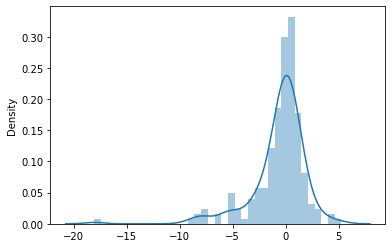

In [463]:
sns.distplot(annual_returns)

In [449]:
np.max(annual_returns)

5.261371477293858

In [450]:
np.mean(annual_returns)

-0.6182564968553873